In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from PIL import Image
import time

from QuantumUtils import QuantumGates as QG
from QuantumUtils import utils as ut
from QuantumUtils import Circuits as cu

import pennylane as qml

In [2]:
# device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using Device: {device}")

dtype = torch.get_default_dtype()
print(f"Using Dtype: {dtype}")

Using Device: cpu
Using Dtype: torch.float32


## Extracting Images

Template Image Shape: torch.Size([9, 9])


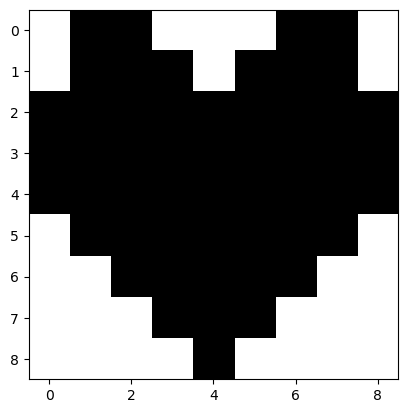

In [3]:
template_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heart_template.png").convert("L")
template_img = torch.tensor(np.array(template_img),dtype=dtype)/255.0
print(f"Template Image Shape: {template_img.shape}")
plt.imshow(template_img,cmap="gray")

template_img = template_img.flatten()

Full Image Shape: torch.Size([32, 32])


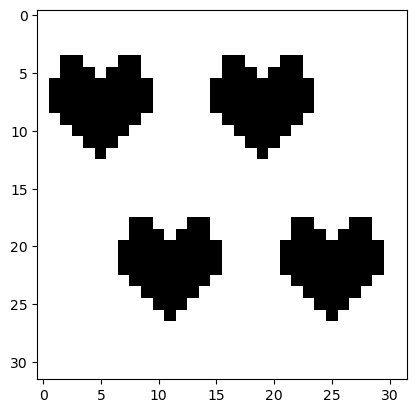

In [4]:
full_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heartss.png").convert("L")
full_img = torch.tensor(np.array(full_img),dtype=dtype)/255.0
print(f"Full Image Shape: {full_img.shape}")

plt.imshow(full_img,cmap="gray")

In [5]:
unfold = torch.nn.Unfold(kernel_size=(9,9), stride=3)
img_patches = unfold(full_img.unsqueeze(0).unsqueeze(0))
img_patches = img_patches.squeeze(0).T

print(f"Number of Image Patches: {img_patches.shape[0]}")
print(f"Single Image Patch Shape: {img_patches.shape[1]}")

Number of Image Patches: 64
Single Image Patch Shape: 81


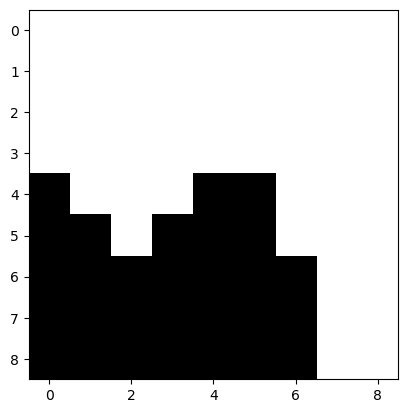

In [6]:
a_patch = img_patches[1].reshape(9,9)
plt.imshow(a_patch, cmap="gray")

In [7]:
### Verifying atleast one patch is similar to the template

def find_similar_patches(img_patches, template_img):
    
    similarity = torch.nn.functional.cosine_similarity(img_patches, template_img.unsqueeze(0), dim=1)
    
    similar_patches = []
    for i in range(len(similarity)):
        if similarity[i] > 0.99:  # Adjust threshold as needed
            similar_patches.append(i)

    if len(similar_patches) == 0:
        print("No patches are identical to the template.")
    else:
        print(f"Found {len(similar_patches)} patches that are identical to the template at indices: {similar_patches}")
    
    return similar_patches



similar_patches = find_similar_patches(img_patches, template_img)


Found 1 patches that are identical to the template at indices: [55]


## Getting density matrices for the images

In [8]:
n_qubits = math.ceil(math.log2(template_img.shape[0]))
n_ancillas = math.ceil(math.log2(img_patches.shape[0]))
total_qubits = n_qubits + n_ancillas
print("Number of main qubits:", n_qubits)
print("Number of ancilla qubits:", n_ancillas)

Number of main qubits: 7
Number of ancilla qubits: 6


In [9]:
def prepare_padded_data(dataset):

    n = math.ceil(math.log2(dataset.shape[1]))
    padded_data = torch.zeros((dataset.shape[0], 2**n))
    padded_data[:, :dataset.shape[1]] = dataset

    for d in padded_data:
        eps = 1e-6
        
        if torch.linalg.norm(d) < 1e-8:
            d = torch.full_like(d, eps)
        d /= torch.linalg.norm(d)

    return padded_data

In [10]:
psi_template_img = prepare_padded_data(template_img.unsqueeze(0)).squeeze(0)

dm_template_img = torch.einsum("i,j -> ij", psi_template_img, psi_template_img)
print(f"Density Matrix Template Image Shape: {dm_template_img.shape}")

Density Matrix Template Image Shape: torch.Size([128, 128])


In [11]:
padded_img_patches = prepare_padded_data(img_patches)

def encode_conditional_state_with_ancilla_last(data,total_qubits):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 64  # because 2^6 = 64 ancilla states

        for j in range(data.shape[0]):
            psi_full[base_index + j] = data[j][i]   

    return psi_full / torch.linalg.norm(psi_full)

psi_img_patches = encode_conditional_state_with_ancilla_last(padded_img_patches, total_qubits)

dm_img_patches = torch.einsum("i,j -> ij", psi_img_patches, psi_img_patches)
print(f"Density Matrix Image Patches Shape: {dm_img_patches.shape}")

Density Matrix Image Patches Shape: torch.Size([8192, 8192])


## Functions

In [12]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real


def qcbm_loss_fn(state:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    px = reduce_statevector(state, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss

In [13]:
def qcbm_circuit(state, params, total_qubits):
    rz_params = params[:total_qubits]
    ry_params = params[total_qubits:2*total_qubits]
    rx_params = params[2*total_qubits:3*total_qubits]

    for i in range(total_qubits):
        state = ut.apply_one_site(site=i, state=state, op=QG.Rx(rx_params[i]))
        state = ut.apply_one_site(site=i, state=state, op=QG.Ry(ry_params[i]))
        state = ut.apply_one_site(site=i, state=state, op=QG.Rz(rz_params[i]))
    
    for i in range(total_qubits - 1):
        cnot = QG.CNOT(control=i, target=i+1, n_qubits=total_qubits)
        state = cnot @ state
    cnot = QG.CNOT(control=total_qubits-1, target=0, n_qubits=total_qubits)
    state = cnot @ state

    return state

In [14]:
class QCBM(torch.nn.Module):

    def __init__(self, n_folds=3, n_qubits=n_qubits, n_ancillas=n_ancillas, total_qubits=total_qubits):
        super().__init__()
        self.n_folds = n_folds
        self.n_qubits = n_qubits
        self.n_ancillas = n_ancillas
        self.total_qubits = total_qubits
        self.params = torch.nn.Parameter(torch.randn(n_folds, 3*total_qubits))
        

    def forward(self, x):
        state = x.to(dtype=torch.complex64, device=x.device)
        for i in range(self.n_folds):
            state = qcbm_circuit(state, self.params[i], self.total_qubits)
        
        return state


In [15]:
model = QCBM()
init_state = torch.zeros(2**total_qubits, dtype=torch.complex64, device=device)
init_state[0] = 1.0  # Initialize the state to |0...0>

opt = torch.optim.Adam(model.parameters(), lr=0.1)
n_epochs = 100

loss_history = []
model.train()
i = 0
while i < n_epochs:
    start_time = time.time()
    opt.zero_grad()
    circuit_output = model(init_state).real
    loss = qcbm_loss_fn(circuit_output, dm_template_img)
    loss.backward()
    opt.step()
    end_time = time.time()
    loss_history.append(loss.item())

    i += 1
    if i%10 == 0:
        print(f"Step: {i} Loss: {loss.item()} Time per step: {end_time - start_time:.4f} seconds")


Step: 10 Loss: 0.3703778087308379 Time per step: 10.7427 seconds
Step: 20 Loss: 0.25095111577132745 Time per step: 10.5301 seconds
Step: 30 Loss: 0.2230362381672269 Time per step: 11.2178 seconds
Step: 40 Loss: 0.2123566649833632 Time per step: 10.5143 seconds
Step: 50 Loss: 0.2041253744788728 Time per step: 10.4989 seconds
Step: 60 Loss: 0.19184270428788544 Time per step: 10.5423 seconds
Step: 70 Loss: 0.17923691819836107 Time per step: 11.0436 seconds
Step: 80 Loss: 0.17698991158098457 Time per step: 11.2623 seconds
Step: 90 Loss: 0.17516485206598306 Time per step: 10.8368 seconds
Step: 100 Loss: 0.17588908544422743 Time per step: 10.8715 seconds


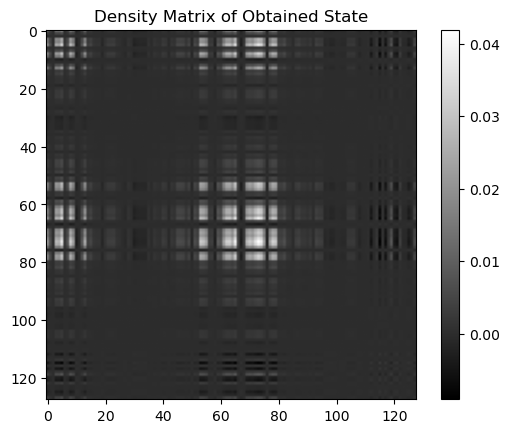

In [28]:
model.eval()
with torch.no_grad():
    final_state = model(init_state).real
    reduced_dm_obtained = reduce_statevector(final_state, indices=range(n_qubits)).real

plt.imshow(reduced_dm_obtained, cmap="gray")
plt.title("Density Matrix of Obtained State")
plt.colorbar()
plt.show()

In [29]:
output = model(init_state).real